# About
This notebooks is a playground for timeseries forecasting, both using simpler regresson models and using neural networks. I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).


## Concepts covered
* Timeseries forecasting
* Moving-average models (ARIMA)
* Neural network model 


## Tools used
* Statsmodels
* Tensorflow

# Imports, setup

In [38]:
import numpy as np
import matplotlib.pyplot as plt


# Artificial timeseries data
In order to study the concepts and tools rather than the data itself, I'll generate an artificial data which still has characteristic properties of timeseries:
* Trend
* Seasonality
* Non-stationarity
* Autocorrelation

In [116]:
num_times = 100
times = np.arange(100)

In [105]:
def trend(times, slope=0.01, start=10):
    return (times - times[0])*slope + start

In [110]:
def noise(times, level=0.5, seed=0):
    rng = np.random.RandomState(0)
    return (rng.rand(*times.shape) - 0.5)*level 

In [117]:
def nonstationarity(times, tail_fraction=0.2):
    """Add trend to tail of series."""
    x = np.zeros(times.shape)
    tail = int(len(times)*tail_fraction)
    x[-tail:]  = trend2[:tail]
    return x

In [ ]:
def autocorrelation():
    pass

In [156]:
def sin_pattern(fraction, k=1, amplitude=0.1):
    return amplitude*np.sin(k*fraction*np.pi) 

In [157]:
def seasonal(times, period=10):
    fractions = (times % period)/period
    return sin_pattern(fractions)

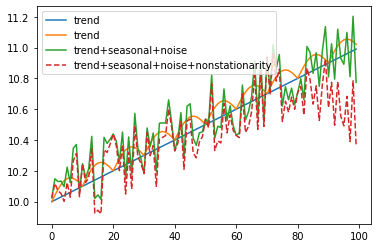

In [173]:
fmt='-'
plt.plot(times, trend(times), fmt, label='trend')
plt.plot(times, trend(times)+seasonal(times), fmt, label='trend')
plt.plot(times, trend(times)+seasonal(times)+noise(times), fmt,  label='trend+seasonal+noise')
tail = 20
plt.plot(times, trend(times)+noise(times)+nonstationarity(times), '--', label='trend+seasonal+noise+nonstationarity')
plt.legend();
